In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

import pickle, time

# pd.set_option("display.max_columns", 100)

In [2]:
df = pd.read_pickle("../../data/total_dataset.pkl") # total dataset
#df = df.drop(["accept_kaon", "accept_muon", "accept_pion", "dilepton_mass"], axis = 1) # signal and background should have the same columns
print("Total dataset number of events: ", len(df))

signal = pd.read_csv("../../data/csv/sig.csv") # as a signal, simulated data is used
print("Number of simulated signal events: ", len(signal))

bg = pd.read_pickle("../../data/pKmumu_piTok_kTop.pkl")
print("Number of background events: ", len(bg))

# labels for decision trees (0 - background; 1 - signal)
vals = np.concatenate([np.zeros(len(bg)), np.ones(len(signal))])
print("Length of labels array", len(vals))

# (X - independent; Y - dependent) variables for the decision tree classifier
X = bg.append(signal) # concatenation of the two dataframes
X = X.drop(["year", "polarity", "Unnamed: 0"], axis = 1) # dropping columns that have not effect, but may have NaN or other inappropriate data
Y = vals

Total dataset number of events:  498357
Number of simulated signal events:  8802
Number of background events:  67526
Length of labels array 76328


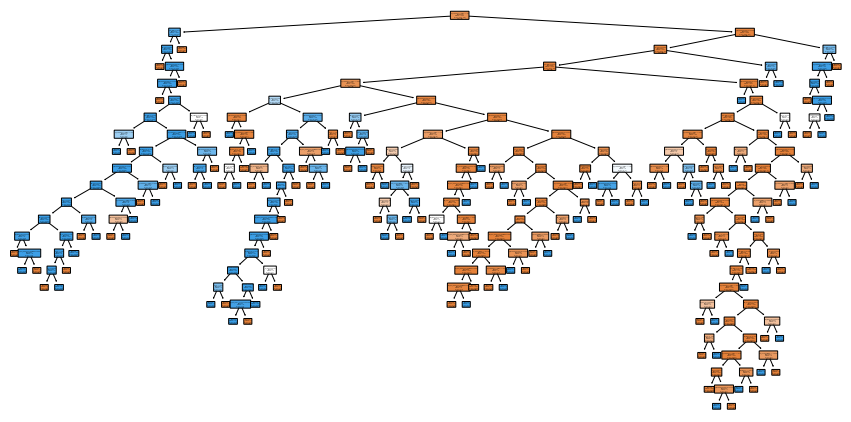

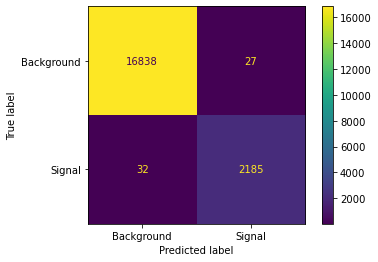

In [3]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y) # splitting data into test and train samples
clf_dt = DecisionTreeClassifier() # creating a Decision Tree
clf_dt = clf_dt.fit(X_train, Y_train) # training it

# Plotting a resulting decision tree
plt.figure(figsize = (15, 7.5))
plot_tree(clf_dt,
         filled = True,
         rounded = True,
         class_names = ["Bg", "Sig"],
         feature_names = X.columns)

# Plotting a confusion matrix, which will check on the test data false-positive and false-negative identifications
plot_confusion_matrix(clf_dt, X_test, Y_test, display_labels = ["Background", "Signal"])

<h3>Next section investigates overfitting prevention</h3>

<h3>End of investigation</h3>

In [4]:
path = clf_dt.cost_complexity_pruning_path(X_train, Y_train)
ccp_alphas = path.ccp_alphas
ccp_alphas = ccp_alphas[:-1] # last one should be removed

print(ccp_alphas)
print(len(ccp_alphas))

[0.00000000e+00 1.71997237e-05 1.73129638e-05 1.73592915e-05
 1.73939240e-05 1.74117536e-05 1.74284958e-05 1.74367201e-05
 1.75151006e-05 2.18161220e-05 2.32418782e-05 2.32912926e-05
 2.60809291e-05 2.62027041e-05 2.70682679e-05 2.79495511e-05
 2.79495511e-05 3.27533801e-05 3.28818248e-05 3.29959978e-05
 3.31062351e-05 3.35394613e-05 3.37322168e-05 3.38099408e-05
 3.38159643e-05 3.40175457e-05 3.42872962e-05 3.45981123e-05
 3.47131253e-05 3.47326292e-05 3.49369388e-05 4.99099126e-05
 5.24054082e-05 5.32022537e-05 6.09808387e-05 6.28864899e-05
 6.35503627e-05 6.58485347e-05 6.73124834e-05 8.38486532e-05
 9.49848024e-05 1.03517940e-04 1.03982901e-04 1.10543158e-04
 1.14394801e-04 1.46354557e-04 1.69685010e-04 1.84878847e-04
 2.26578537e-04 2.31887959e-04 3.84484781e-04 4.14836855e-04
 6.35492128e-04 6.53582189e-04 8.17514343e-04 1.98066524e-03
 2.27513322e-03 2.84869488e-03 3.67968148e-03 7.89026243e-03
 1.50065704e-02]
61


Starting alpha num:  0
Execution time for alpha:  29.676735877990723
Starting alpha num:  1
Execution time for alpha:  29.268617868423462
Starting alpha num:  2
Execution time for alpha:  29.25151515007019
Starting alpha num:  3
Execution time for alpha:  29.17599129676819
Starting alpha num:  4
Execution time for alpha:  29.443117141723633
Starting alpha num:  5
Execution time for alpha:  29.352489233016968
Starting alpha num:  6
Execution time for alpha:  29.78288173675537
Starting alpha num:  7
Execution time for alpha:  29.307226181030273
Starting alpha num:  8
Execution time for alpha:  29.16480016708374
Starting alpha num:  9
Execution time for alpha:  29.22813582420349
Starting alpha num:  10
Execution time for alpha:  30.95807909965515
Starting alpha num:  11
Execution time for alpha:  30.30821681022644
Starting alpha num:  12
Execution time for alpha:  29.27589464187622
Starting alpha num:  13
Execution time for alpha:  29.52871870994568
Starting alpha num:  14
Execution time 

<AxesSubplot:xlabel='alpha'>

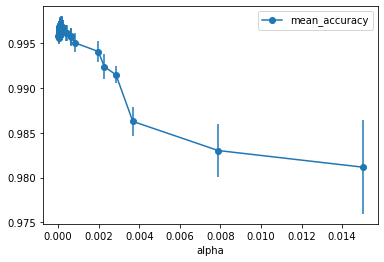

In [5]:
alpha_loop_values = []
# Check different alpha values with cross validation providing errorbars
init_time = time.time()
for num, ccp_alpha in enumerate(ccp_alphas): # not all alphas are used to save some time - for better precision all ccp_alphas should be looked at
    print("Starting alpha num: ", num)
    start_time = time.time()
    clf_dt = DecisionTreeClassifier(ccp_alpha = ccp_alpha)
    scores = cross_val_score(clf_dt, X_train, Y_train, cv = 5)
    alpha_loop_values.append([ccp_alpha, np.mean(scores), np.std(scores)])
    print("Execution time for alpha: ", time.time() - start_time)
print("Total execution time: ", time.time() - init_time)
    
alpha_results = pd.DataFrame(alpha_loop_values, columns = ["alpha", "mean_accuracy", "std"])

alpha_results.plot(x = 'alpha', y = 'mean_accuracy', yerr = 'std', marker = 'o')

<AxesSubplot:xlabel='alpha'>

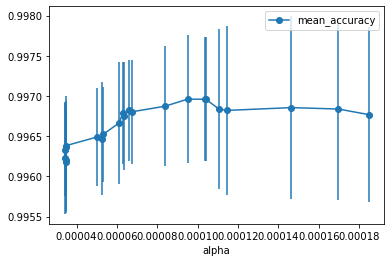

In [13]:
# find the best alpha in terms of absolute accuracy and its error
alpha_results[25:-13].plot(x = 'alpha', y = 'mean_accuracy', yerr = 'std', marker = 'o')


0.00010351793995220843


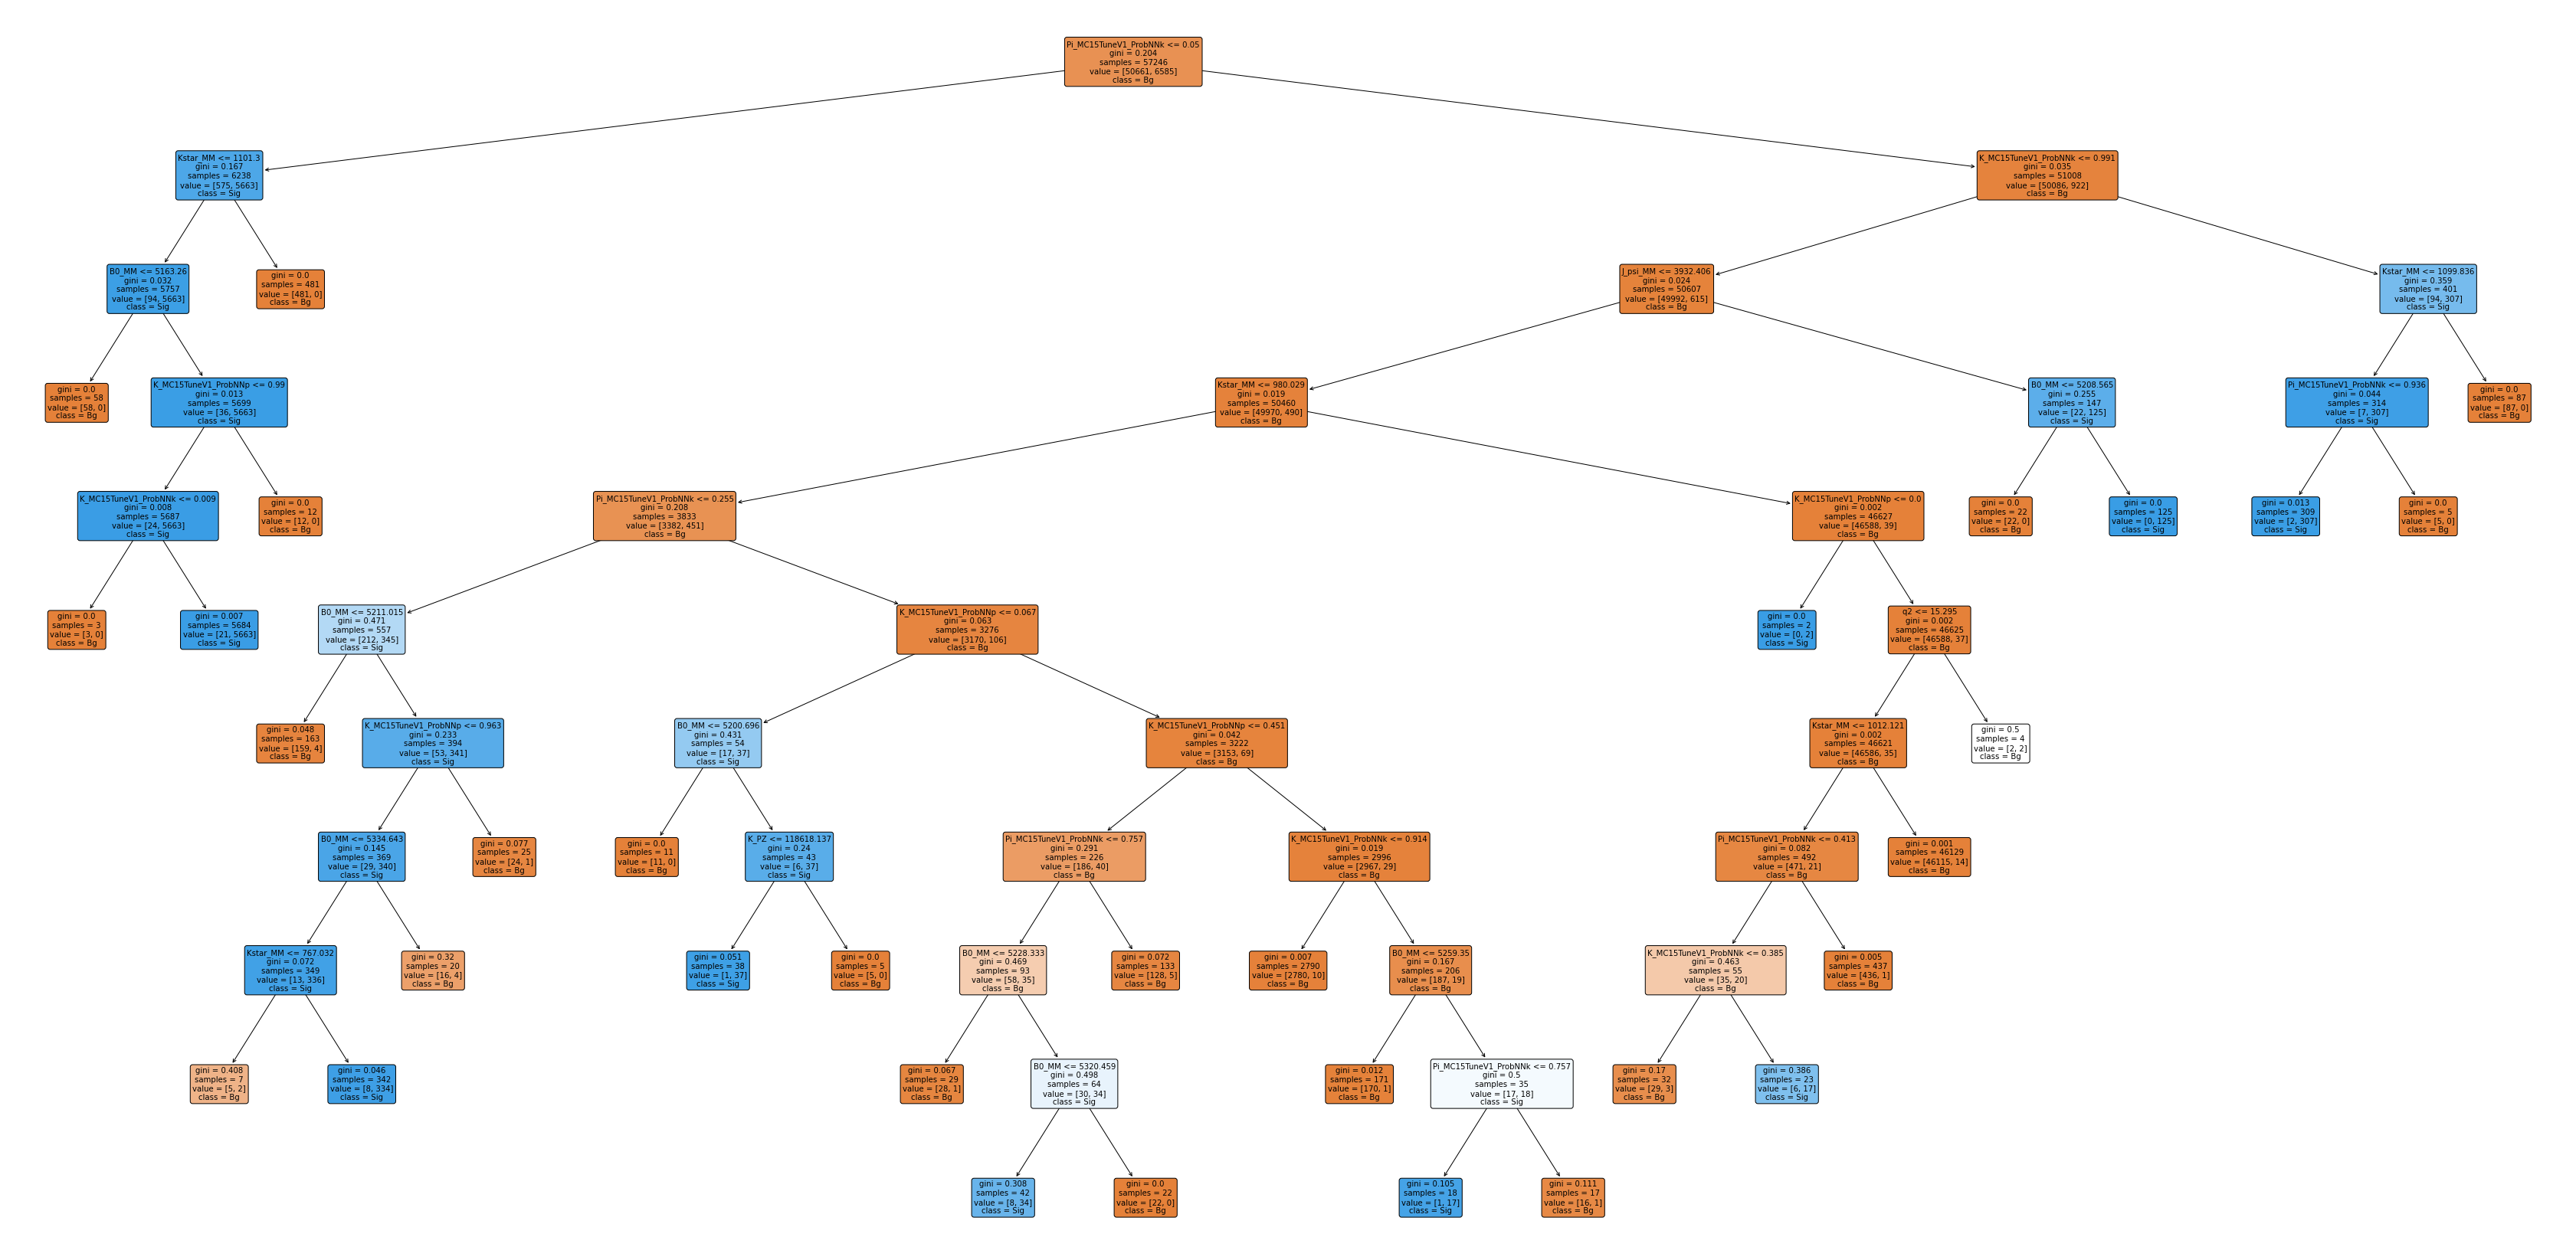

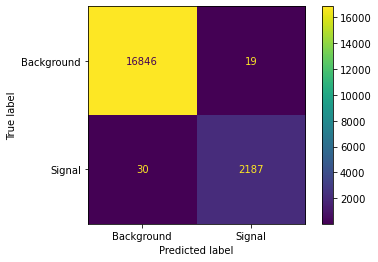

In [14]:
# Extract the best value of alpha
ideal_alpha = ccp_alphas[(ccp_alphas > 0.0001) & (ccp_alphas < 0.00011)][0]
ideal_alpha = float(ideal_alpha)
print(ideal_alpha)

# Resulting decision tree with the ccp_alpha being used to prevent overfitting
clf_dt = DecisionTreeClassifier(ccp_alpha = ideal_alpha)
clf_dt = clf_dt.fit(X_train, Y_train)

plt.figure(figsize = (60, 30))
plot_tree(clf_dt,
         filled = True,
         rounded = True,
         class_names = ["Bg", "Sig"],
         feature_names = X.columns)

# Corresponding confusion matrix
plot_confusion_matrix(clf_dt, X_test, Y_test, display_labels = ["Background", "Signal"])

In [15]:
with open("tree_pKmumu_piTok_kTop", 'wb') as f: # exporting decision tree to 'tree_jpsi' binary file
    pickle.dump(clf_dt, f)

Number of bg (0) and signal (1) events identified (array([0., 1.]), array([212745, 285612], dtype=int64))


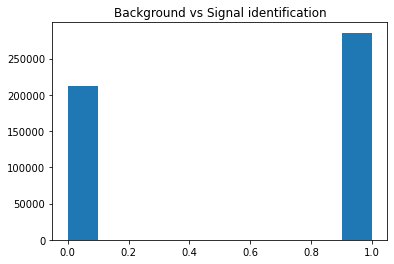

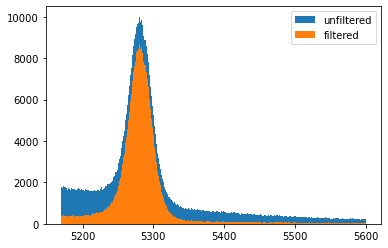

In [16]:
df = pd.read_pickle("../../data/total_dataset.pkl")
#df = df.drop(["accept_kaon", "accept_muon", "accept_pion", "dilepton_mass"], axis = 1)
#print("Total number of events:", len(df))
#total_data = df[(df["B0_MM"] > min_mass) & (df["B0_MM"] < max_mass)].drop(["year", "polarity", "Unnamed: 0"], axis = 1)
#print("Number of events in the mass region", len(total_data))

# Passing data to decision tree
result = clf_dt.predict(df.drop(["year", "polarity"], axis = 1))

print("Number of bg (0) and signal (1) events identified", np.unique(result, return_counts = True))
plt.title("Background vs Signal identification")
plt.hist(result)
plt.show()

# Extracting signal data to 'Filtered_data.pkl'
df["Result"] = result
filtered = df[df["Result"] == 1]
filtered.to_pickle("Filtered_data.pkl")

# Histogram of the filtered data
plt.hist(df['B0_MM'], range=[5170, 5600], bins=300, zorder=1, label = "unfiltered")
plt.hist(filtered['B0_MM'], range=[5170, 5600], bins=300, zorder=2, label = "filtered")
plt.legend()
plt.show()